<span style="font-family:Calibri; font-size:3em; color:blue">IEEE Fraud Detection</span>


https://www.kaggle.com/a03102030/eda-for-train-data-and-lgbm-lr


https://www.kaggle.com/jesucristo/fraud-complete-eda


https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda



<br>
<img src="https://cdn.datafloq.com/cache/blog_pictures/878x531/fraud-analytics-protect-banking-sector.jpg" width="500" height="600">
<br>


**Why fraud detection?**
> Fraud is a billion-dollar business and it is increasing every year. The PwC global economic crime survey of 2018[1] found that half (49 percent) of the 7,200 companies they surveyed had experienced fraud of some kind. This is an increase from the PwC 2016 study in which slightly more than a third of organizations surveyed (36%) had experienced economic crime.


This competition is a **binary classification** problem - i.e. our target variable is a binary attribute (Is the user making the click fraudlent or not?) and our goal is to classify users into "fraudlent" or "not fraudlent" as well as possible.

Unlike metrics such as ```LogLoss```, the **AUC score** only depends on how well you well you can separate the two classes. In practice, this means that only the order of your predictions matter, as a result of this, any rescaling done to your model's output probabilities will have no effect on your score. [click here to read more about AUC-ROC](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it)

<img src='https://upload.wikimedia.org/wikipedia/commons/6/6b/Roccurves.png' width=300 height=300>


### Content

- Data exploration
- Missing Data.
- Imbalanced problem.


- Plots
    - Distribution plots
    - Count plots
    - Unique values
    - Groups
    
    
- Memory reduction  

- PCA


- Models
    - XGBoost Model.
    - LGBM
    
**Remember the <span style="color:red">upvote</span> button is next to the fork button, and it's free too! ;)**

----

### References:

- https://www.kaggle.com/artgor/eda-and-models/data
- https://www.kaggle.com/artkulak/ieee-fraud-simple-baseline-0-9383-lb
- https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda
- https://www.kaggle.com/mjbahmani/reducing-memory-size-for-ieee

<br>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

In [17]:
import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Any results you write to the current directory are saved as output.
print ("Ready!")

Ready!


# E.D.A


In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target ```isFraud```.

The data is broken into two files **identity** and **transaction**, which are joined by ```TransactionID```. 

> Note: Not all transactions have corresponding identity information.

**Categorical Features - Transaction**

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features - Identity**

- DeviceType
- DeviceInfo
- id_12 - id_38

**The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).**

**Files**

- train_{transaction, identity}.csv - the training set
- test_{transaction, identity}.csv - the test set (**you must predict the isFraud value for these observations**)
- sample_submission.csv - a sample submission file in the correct format


## Loading Data

In [13]:
import os 
print('# File sizes')
for f in os.listdir('input'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('input/' + f) / 1000000, 2)) + 'MB')

# File sizes
sample_submission.csv         6.08MB
test_identity.csv             25.8MB
test_transaction.csv          613.19MB
train_identity.csv            26.53MB
train_transaction.csv         683.35MB


In [43]:
%%time
train_transaction = pd.read_csv('input/train_transaction.csv')
test_transaction = pd.read_csv('input/test_transaction.csv')
train_identity = pd.read_csv('input/train_identity.csv')
test_identity = pd.read_csv('input/test_identity.csv')
print ("Data is loaded!")

Data is loaded!
Wall time: 35 s


In [20]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 393)
test_transaction shape is (506691, 392)
train_identity shape is (144233, 40)
test_identity shape is (141907, 40)


In [44]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


## Train / Test Split Lookup



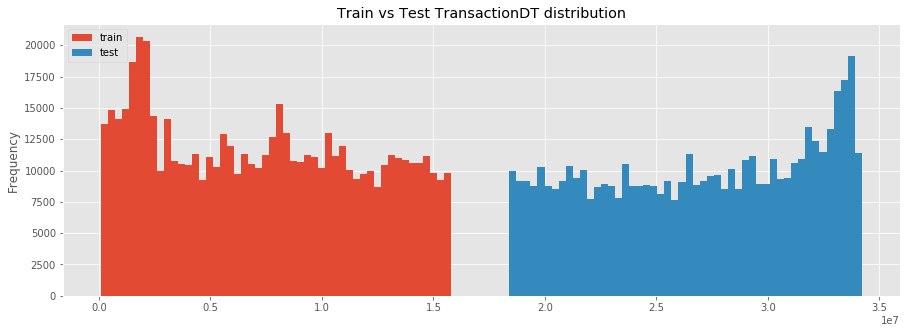

In [46]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

In [32]:
import warnings
warnings.simplefilter("ignore")
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

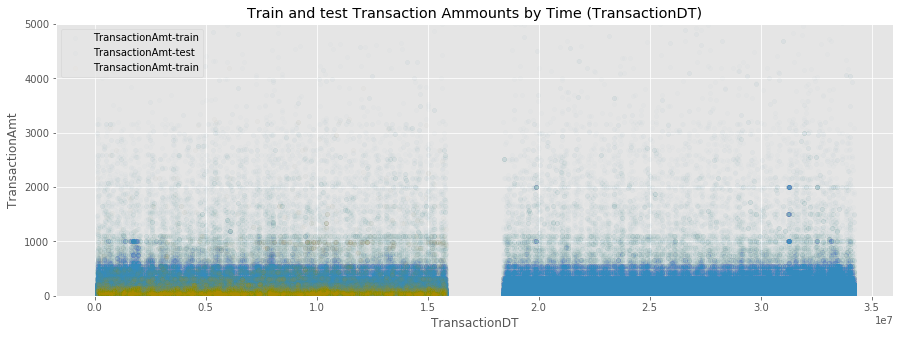

In [47]:
ax = train_transaction.plot(x='TransactionDT',
                       y='TransactionAmt',
                       kind='scatter',
                       alpha=0.01,
                       label='TransactionAmt-train',
                       title='Train and test Transaction Ammounts by Time (TransactionDT)',
                       ylim=(0, 5000),
                       figsize=(15, 5))
test_transaction.plot(x='TransactionDT',
                      y='TransactionAmt',
                      kind='scatter',
                      label='TransactionAmt-test',
                      alpha=0.01,
                      color=color_pal[1],
                       ylim=(0, 5000),
                      ax=ax)

# Plot Fraud as Orange
train_transaction.loc[train_transaction['isFraud'] == 1] \
    .plot(x='TransactionDT',
         y='TransactionAmt',
         kind='scatter',
         alpha=0.01,
         label='TransactionAmt-train',
         title='Train and test Transaction Ammounts by Time (TransactionDT)',
         ylim=(0, 5000),
         color='orange',
         figsize=(15, 5),
         ax=ax)
plt.show()

# First Problem we need to solve : MISSING VALUES

Remember
> Not all transactions have corresponding identity information

OK, there are a lot of **NaN** and **interesting columns**: 

- ``` C1, C2 ... D1, V300, V339 ... ``` 
- ``` id_01 ... id_38``` 

The columns with those names don't look friendly.
Apparently we don't have **dates**.

**train_transaction**

In [24]:
missing_values_count = train_transaction.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_transaction.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
card6             1571
dtype: int64
% of missing data =  41.17794374769424


**train_identity**

In [25]:
missing_values_count = train_identity.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_identity.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

id_01         0
id_02      3361
id_03     77909
id_04     77909
id_05      7368
id_06      7368
id_07    139078
id_08    139078
id_09     69307
id_10     69307
dtype: int64
% of missing data =  36.47062392101669


In [26]:
del missing_values_count, total_cells, total_missing

Text(0.5, 1.0, 'counts of missing value for train_identity')

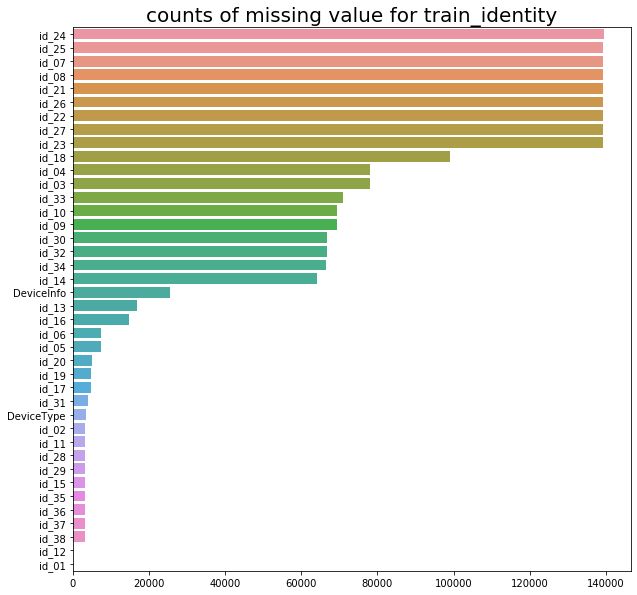

In [28]:
plt.figure(figsize=(10,10))
sns.barplot(x=train_identity.isnull().sum().sort_values(ascending=False),y=train_identity.isnull().sum().sort_values(ascending=False).index)
plt.title("counts of missing value for train_identity",size=20)

Text(0.5, 1.0, 'counts of missing value for train_transaction')

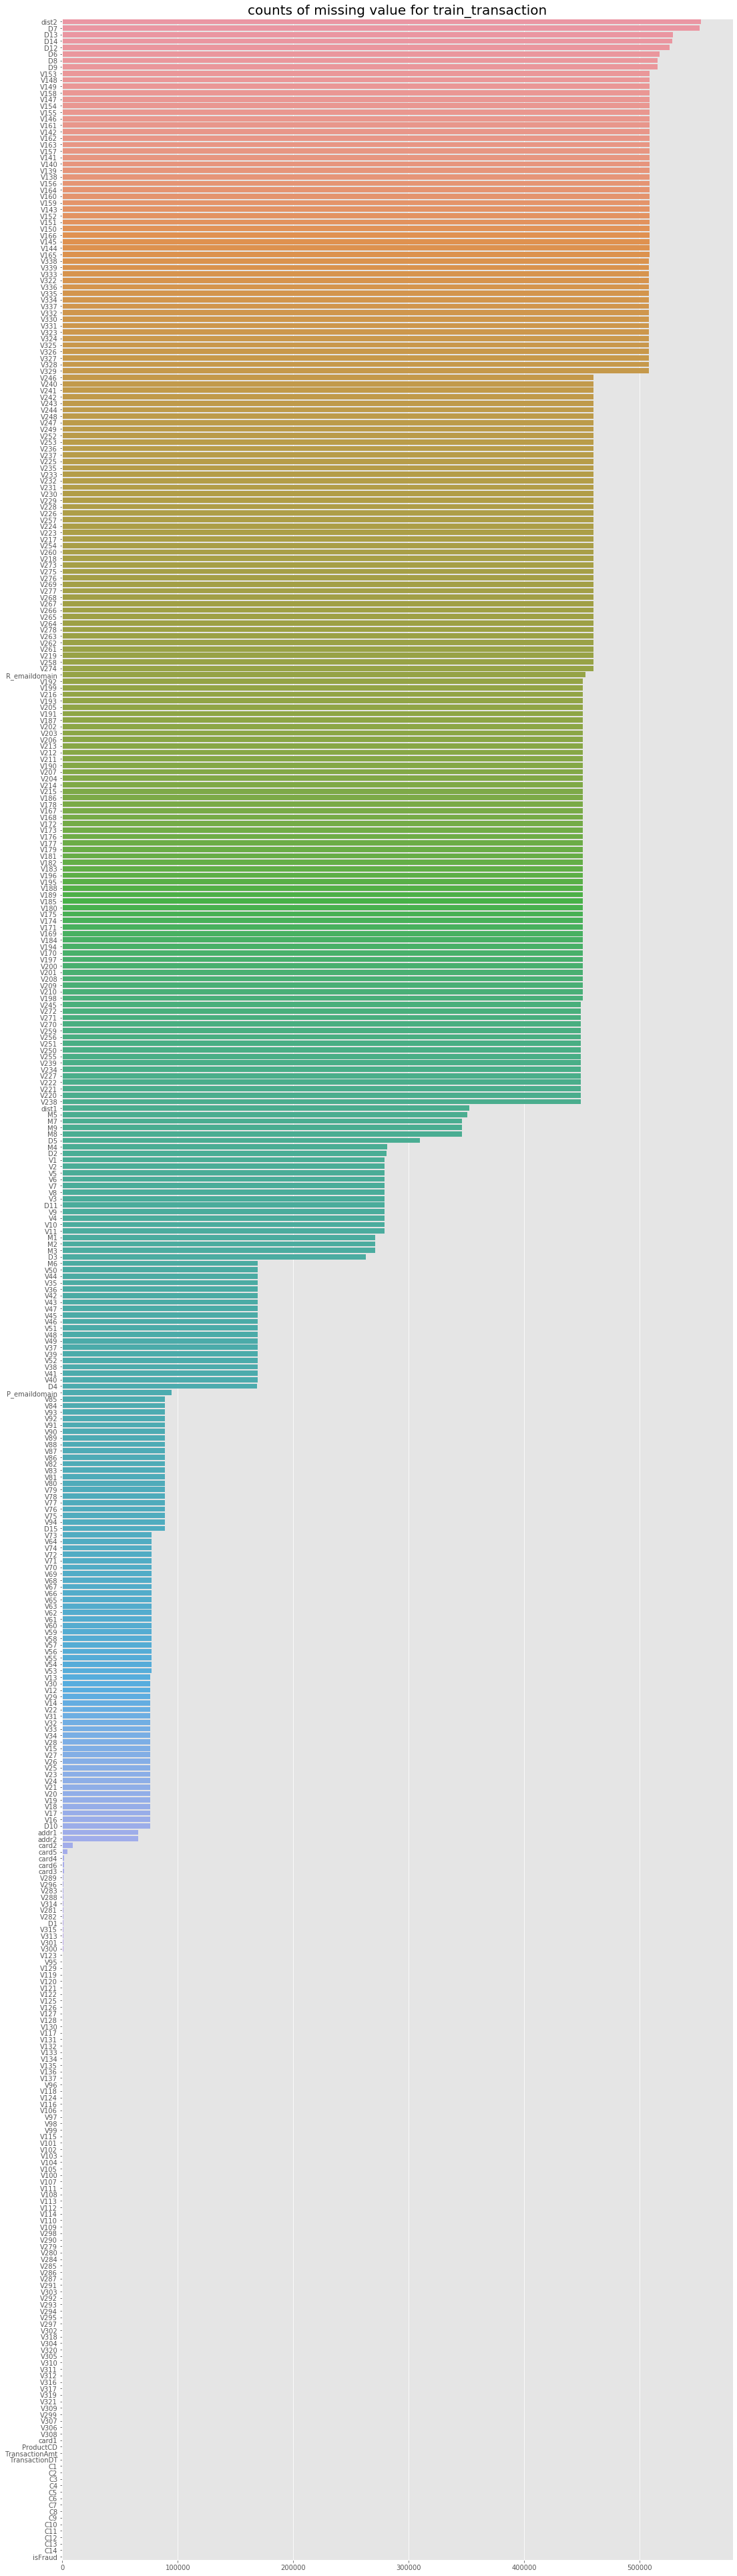

In [35]:
plt.figure(figsize=(18,70))
sns.barplot(x=train_transaction.isnull().sum().sort_values(ascending=False),y=train_transaction.isnull().sum().sort_values(ascending=False).index)
plt.title("counts of missing value for train_transaction",size=20)

# Second Problem we need to solve : CLASS IMBALANCE

Notice how **imbalanced** is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

**Imbalance** means that the number of data points available for different the classes is different

<img src='https://www.datascience.com/hs-fs/hubfs/imbdata.png?t=1542328336307&width=487&name=imbdata.png'>

In [36]:
print('  {:.4f}% of Transactions that are fraud in train '.format(train_transaction['isFraud'].mean() * 100))

  3.4990% of Transactions that are fraud in train 


In [48]:
train_transaction.groupby('isFraud').head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203,2987203,1,89760,445.000,W,18268,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,2987240,1,90193,37.098,C,13413,103.0,185.0,visa,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,2987243,1,90246,37.098,C,13413,103.0,185.0,visa,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2987245,1,90295,37.098,C,13413,103.0,185.0,visa,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,2987288,1,90986,155.521,C,16578,545.0,185.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


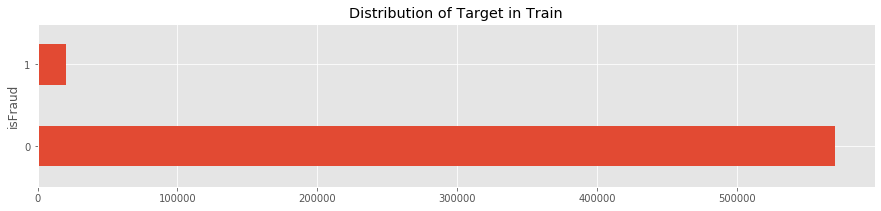

In [51]:
train_transaction.groupby('isFraud') \
    .count()['TransactionID'] \
    .plot(kind='barh',
          title='Distribution of Target in Train',
          figsize=(15, 3))
plt.show()

__3.5% of transacations are fraud__

# Time vs fe
> **The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).**

**Important ! read the post [The timespan of the dataset is 1 year ?
](https://www.kaggle.com/c/ieee-fraud-detection/discussion/100071#latest-577632) by Suchith**

```
Train: min = 86400 max = 15811131
Test: min = 18403224 max = 34214345
```

The difference train.min() and test.max() is ```x = 34214345 - 86400 = 34127945``` but we don't know is it in seconds,minutes or hours.

```
Time span of the total dataset is 394.9993634259259 days
Time span of Train dataset is  181.99920138888888 days
Time span of Test dataset is  182.99908564814814 days
The gap between train and test is 30.00107638888889 days
```

If it is in seconds then dataset timespan will be ```x/(3600*24*365) = 1.0821``` years which seems reasonable to me. So if the **transactionDT** is in **seconds** then

```
Time span of the total dataset is 394.9993634259259 days
Time span of Train dataset is  181.99920138888888 days
Time span of Test dataset is  182.99908564814814 days
The gap between train and test is 30.00107638888889 days
```


![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2370491%2Fc9bf5af5e902595b737df5470adc193b%2Fdownload-1.png?generation=1563312982845419&alt=media)

**source: [FChmiel](https://www.kaggle.com/fchmiel)**
<br>

In [52]:
# Here we confirm that all of the transactions in `train_identity`
print(np.sum(train_transaction.index.isin(train_identity.index.unique())))
print(np.sum(test_transaction.index.isin(test_identity.index.unique())))

144233
141907


```24.4%``` of TransactionIDs in train (144233 / 590540) have an associated train_identity.

```28.0%``` of TransactionIDs in test (144233 / 590540) have an associated train_identity.

In [53]:
train_transaction['TransactionDT'].head()

0    86400
1    86401
2    86469
3    86499
4    86506
Name: TransactionDT, dtype: int64

In [54]:
train_transaction['TransactionDT'].shape[0] , train_transaction['TransactionDT'].nunique()

(590540, 573349)

**TransactionDT** is not a timestamp, but somehow we use it to measure time.

In [55]:
train_transaction['TransactionDT'].value_counts().head(10)

9474817     8
11576951    5
7236588     5
4397066     5
8468062     4
8020359     4
7337054     4
5334992     4
1971839     4
1962054     4
Name: TransactionDT, dtype: int64

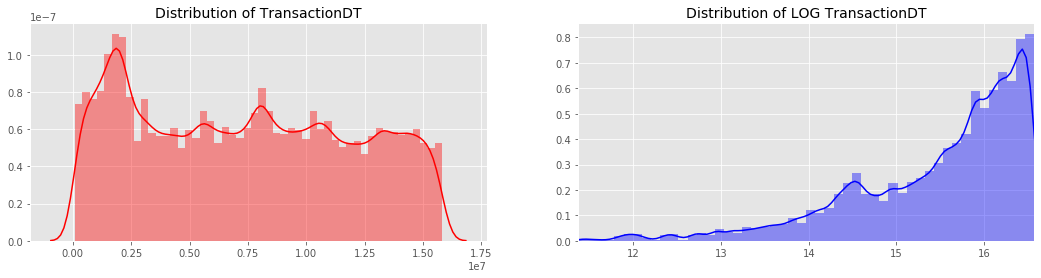

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction['TransactionDT'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionDT', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

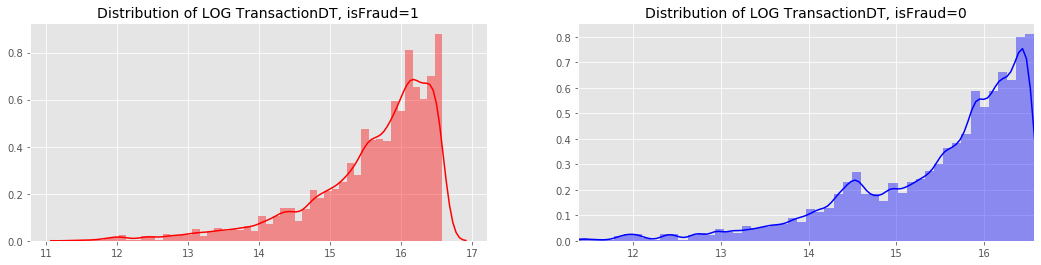

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionDT, isFraud=1', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

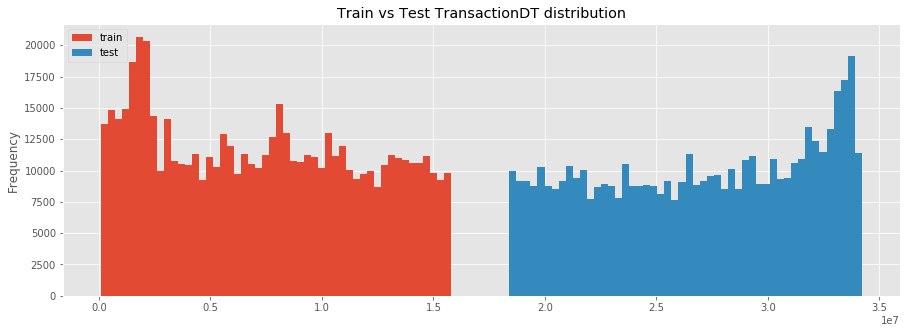

In [58]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

As you can see it seems that train and test transaction dates don't overlap, so it would be prudent to use time-based split for validation. Rob discovered this here: https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda.

Also we can see the **30 days** gap between train and test.


In [59]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Also you should read this post by Rob [Plotting features over time shows something.... interesting
](https://www.kaggle.com/c/ieee-fraud-detection/discussion/100167#latest-577688) he discovered a weird correlation between C and D features, and that's why I do the following plots :)

### isFraud vs time

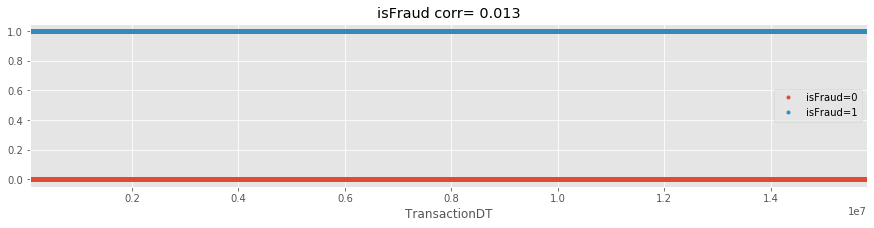

In [60]:
i = 'isFraud'
cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
train_transaction.loc[train_transaction['isFraud'] == 0].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
train_transaction.loc[train_transaction['isFraud'] == 1].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
#test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
plt.legend()
plt.show()

### Email Domain

In [68]:
"emaildomain" in train_transaction.columns, "emaildomain" in train_identity.columns

(False, False)

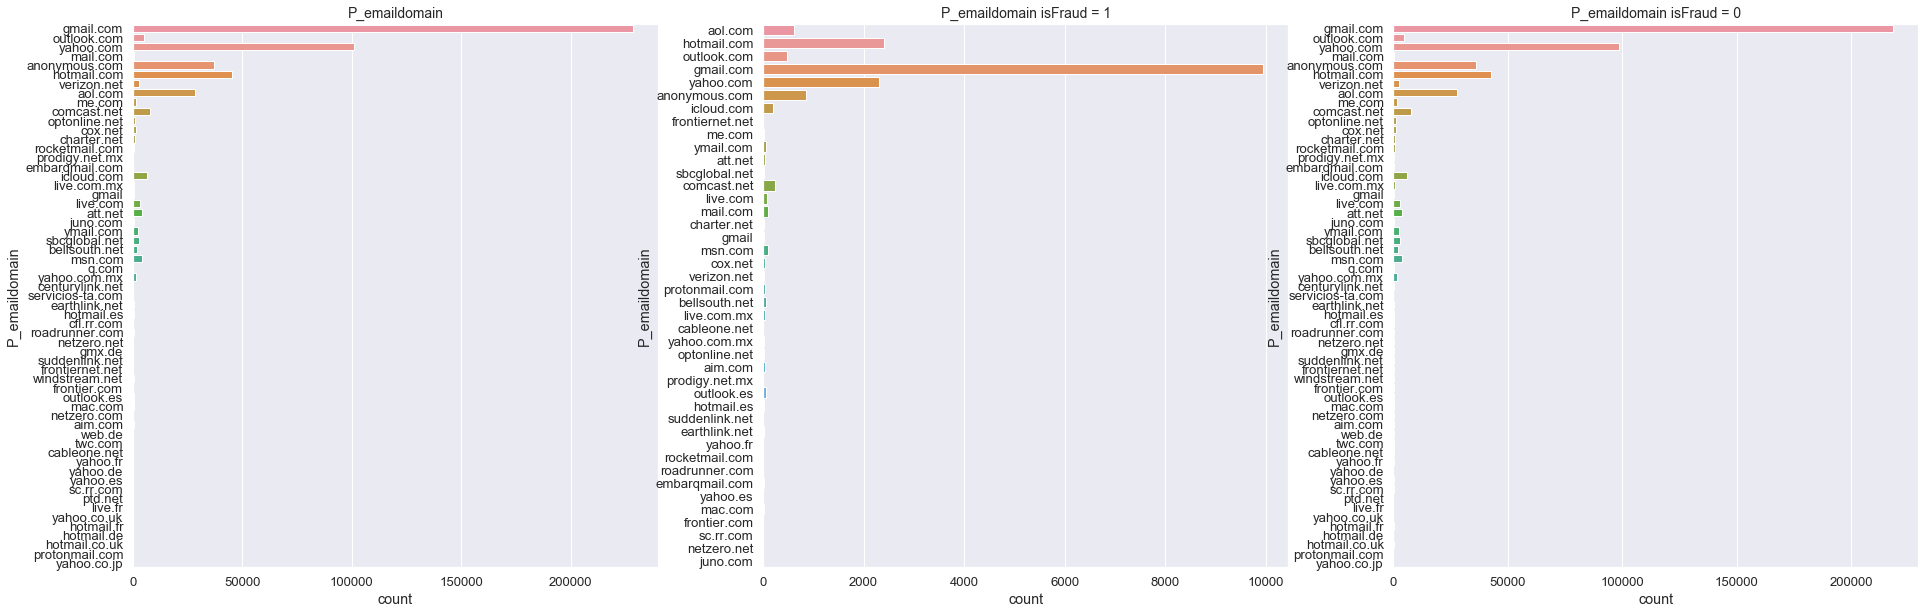

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(32,10))

sns.countplot(y="P_emaildomain", ax=ax[0], data=train_transaction)
ax[0].set_title('P_emaildomain', fontsize=14)
sns.countplot(y="P_emaildomain", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('P_emaildomain isFraud = 1', fontsize=14)
sns.countplot(y="P_emaildomain", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('P_emaildomain isFraud = 0', fontsize=14)
plt.show()

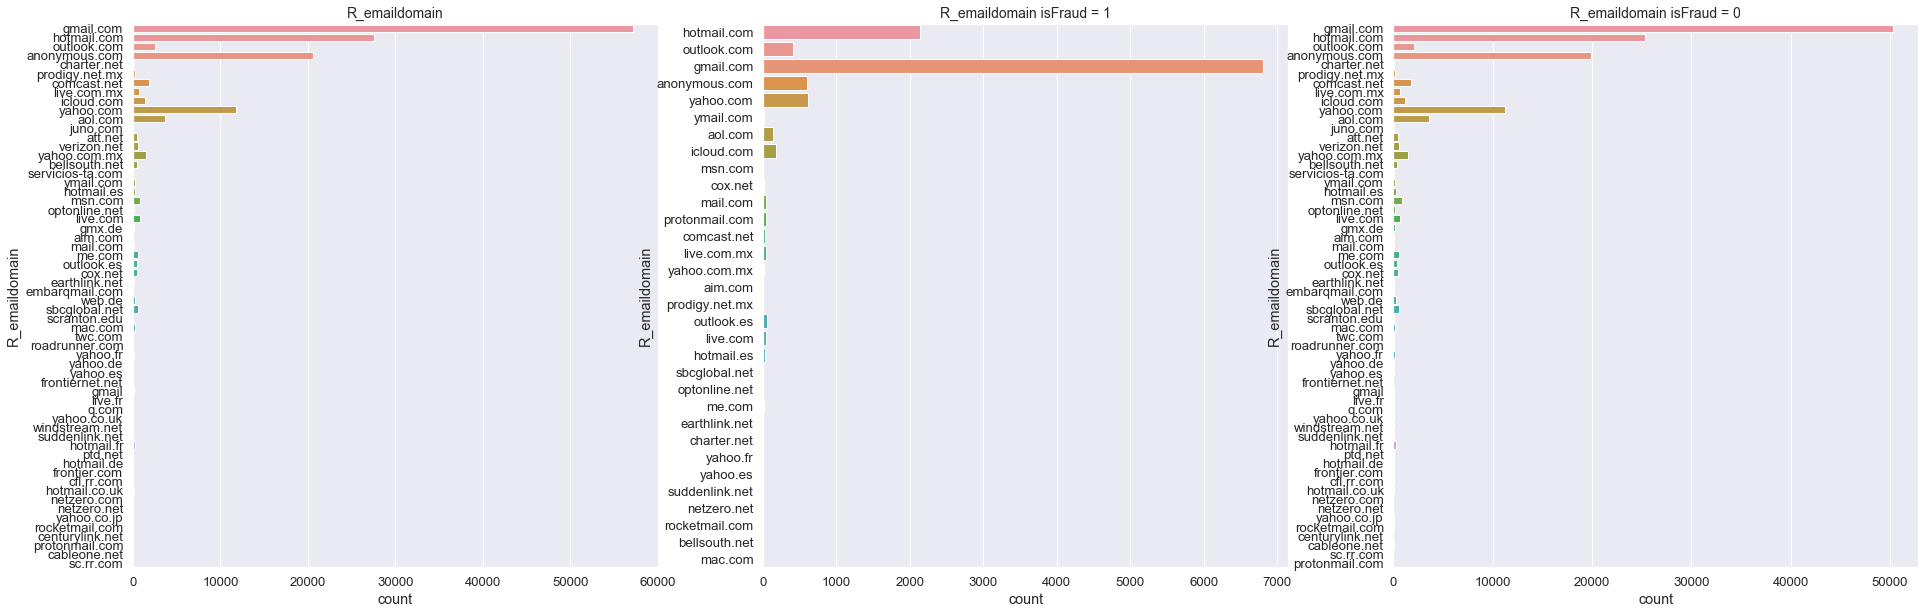

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(32,10))

sns.countplot(y="R_emaildomain", ax=ax[0], data=train_transaction)
ax[0].set_title('R_emaildomain', fontsize=14)
sns.countplot(y="R_emaildomain", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('R_emaildomain isFraud = 1', fontsize=14)
sns.countplot(y="R_emaildomain", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('R_emaildomain isFraud = 0', fontsize=14)
plt.show()

It seems that criminals prefer gmail

# Memory reduction

**Merge transaction & identity + Label Encoder**

In [71]:
%%time
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
y_train = train['isFraud'].astype("uint8").copy()
print("Tain: ",train.shape)
del train_transaction, train_identity

test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
print("Test: ",test.shape)
del test_transaction, test_identity
print ("Merged!")

Tain:  (590540, 435)
Test:  (506691, 434)
Merged!
Wall time: 2.97 s


In [72]:
%%time
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test
gc.collect()

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))  

Wall time: 1min 6s


# Reduce Memory Usage


In [73]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Wall time: 0 ns


this takes 6-7 mins. You can click and check the ``` output ```

In [74]:
%%time
X_train = reduce_mem_usage2(X_train)
X_test = reduce_mem_usage2(X_test)

Memory usage of dataframe is 1955.37 MB
Memory usage after optimization is: 527.14 MB
Decreased by 73.0%
Memory usage of dataframe is 1677.73 MB
Memory usage after optimization is: 460.02 MB
Decreased by 72.6%
Wall time: 4min 24s


### Now memory should be around 4 GB !

In [75]:
X_train.head(3)

,TransactionID_x,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,86400,68.5,4,13926,NaN,150.0,1,142.0,1,...,162,32.0,268,3,1,0,1,1,1,1565
1,2987001,86401,29.0,4,2755,404.0,150.0,2,102.0,1,...,130,32.0,80,2,1,0,0,1,1,2693
2,2987002,86469,59.0,4,4663,490.0,150.0,4,166.0,2,...,46,NaN,461,4,0,0,1,1,0,2526


In [76]:
X_test.head(3)

,TransactionID_x,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,4,10409,111.0,150.0,4,226.0,2,...,62,NaN,461,4,0,0,1,0,1,1168
1,3663550,18403263,49.000000,4,4272,111.0,150.0,4,226.0,2,...,62,24.0,62,3,1,0,1,1,1,1031
2,3663551,18403310,171.000000,4,4476,574.0,150.0,4,226.0,2,...,124,NaN,461,4,0,1,1,0,0,2459


In [82]:
logging.debug("memory usage!")

DEBUG:root:memory usage!


**Drop some columns**
> from: https://www.kaggle.com/jazivxt/safe-box/notebook

In [77]:
#drop_col = ['TransactionDT', 'V300', 'V309', 'V111', 'C3', 'V124', 'V106', 'V125', 'V315', 'V134', 'V102', 'V123', 'V316', 'V113', 'V136', 'V305', 'V110', 'V299', 'V289', 'V286', 'V318', 'V103', 'V304', 'V116', 'V298', 'V284', 'V293', 'V137', 'V295', 'V301', 'V104', 'V311', 'V115', 'V109', 'V119', 'V321', 'V114', 'V133', 'V122', 'V319', 'V105', 'V112', 'V118', 'V117', 'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120']
drop_col = ['TransactionDT', 'TransactionID_x']
X_train.drop(drop_col,axis=1, inplace=True)
X_test.drop(drop_col, axis=1, inplace=True)
X_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,...,162,32.0,268,3,1,0,1,1,1,1565
1,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,...,130,32.0,80,2,1,0,0,1,1,2693
2,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,...,46,NaN,461,4,0,0,1,1,0,2526
3,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,...,46,NaN,461,4,0,0,1,1,0,2740
4,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,87.0,...,46,24.0,68,3,1,0,1,1,0,1170


**Fill NaN**

In [78]:
X_train.fillna(-1,inplace=True)
X_test.fillna(-1,inplace=True)
X_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,4,13926,-1.0,150.0,1,142.0,1,315.0,87.0,...,162,32.0,268,3,1,0,1,1,1,1565
1,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,...,130,32.0,80,2,1,0,0,1,1,2693
2,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,...,46,-1.0,461,4,0,0,1,1,0,2526
3,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,...,46,-1.0,461,4,0,0,1,1,0,2740
4,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,87.0,...,46,24.0,68,3,1,0,1,1,0,1170


# PCA

**PCA 2 components**

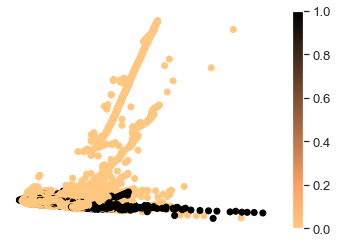

In [79]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)         
PCA_train_x = PCA(2).fit_transform(train_scaled)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

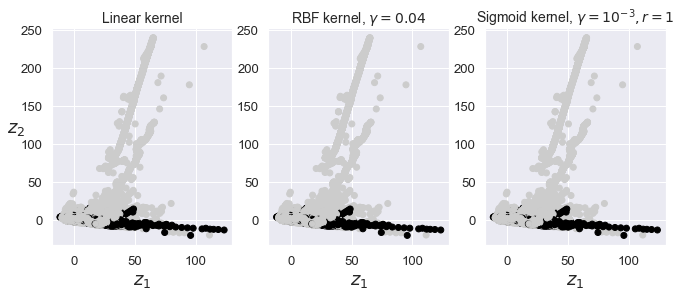

In [80]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    PCA_train_x = PCA(2).fit_transform(train_scaled)
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap="nipy_spectral_r")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [83]:
del train_scaled,PCA_train_x,scaler, lin_pca,rbf_pca, sig_pca
gc.collect()

10420

<br>
# Models
---


# XGBoost Model + FE Importance

> This part is from [can_we_beat_it](https://www.kaggle.com/konradb/can-we-beat-it) by Konrad

> Also check this kernel [IEEE Fraud Simple Baseline [0.9383 LB]](https://www.kaggle.com/artkulak/ieee-fraud-simple-baseline-0-9383-lb)

In [84]:
xgb.XGBClassifier(
        n_estimators=500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma = 0.1,
        alpha = 4,
        missing = -1,
        tree_method='gpu_hist'
)

XGBClassifier(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-1, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=1)

**Important** Check the [XGB official documentation](https://xgboost.readthedocs.io/en/latest/parameter.html) in order to know more about the parameters.

Also check this thread [CV vs Public LB](https://www.kaggle.com/c/ieee-fraud-detection/discussion/100255#latest-578503)

In [85]:
%%time
NFOLDS = 5
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=123)

y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
  
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    clf = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma = 0.2,
        alpha = 4,
        missing = -1,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print("FOLD: ",fold,' AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    score += roc_auc_score(y_vl, y_pred_train) / NFOLDS
    y_preds+= clf.predict_proba(X_test)[:,1] / NFOLDS
    
    del X_tr, X_vl, y_tr, y_vl
    gc.collect()
    
    
print("\nMEAN AUC = {}".format(score))
print("OOF AUC = {}".format(roc_auc_score(y_train, y_oof)))

FOLD:  0  AUC 0.9615144951116582
FOLD:  1  AUC 0.9628445810139187
FOLD:  2  AUC 0.9623122416756257
FOLD:  3  AUC 0.9608974121590073
FOLD:  4  AUC 0.9609601626263127

MEAN AUC = 0.9617057785173045
OOF AUC = 0.9616978178324689
Wall time: 6min 42s


### Importance PLOT
> last FOLD

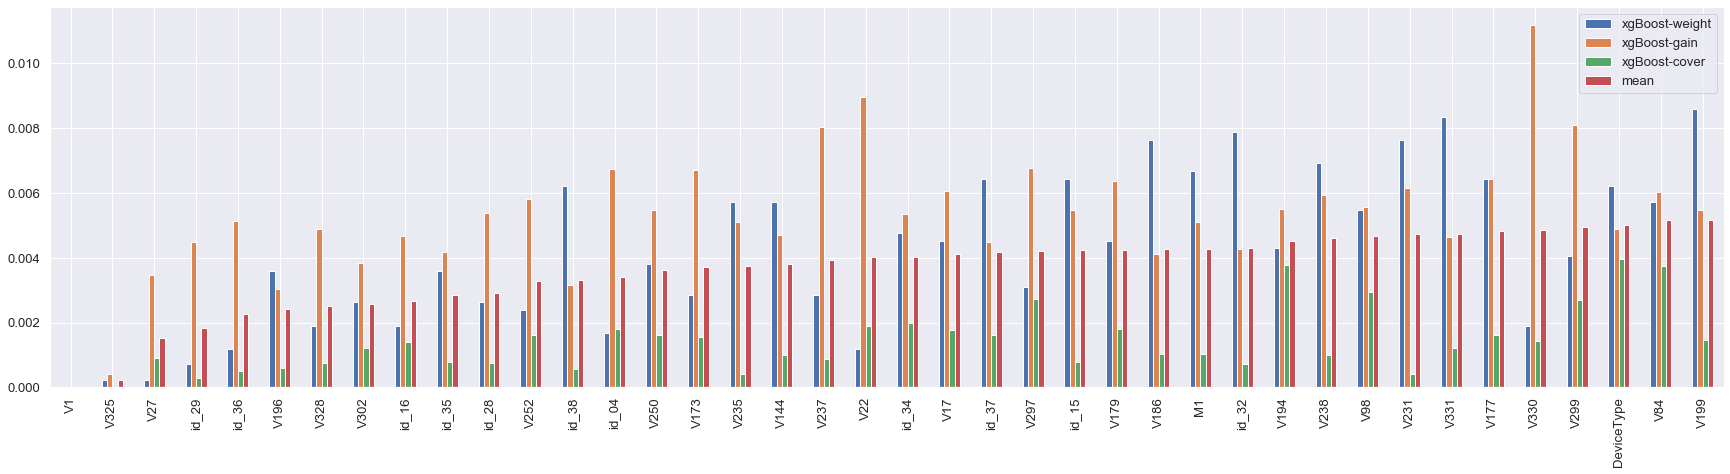

In [86]:
# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').head(40).plot(kind='bar', figsize=(30, 7))


In [87]:
del clf, importance_df
gc.collect()

62

# Submission

In [89]:
sub = pd.read_csv('input/sample_submission.csv', index_col='TransactionID')
sub['isFraud'] = y_preds
sub.to_csv('xgboost.csv')
sub.head()

,isFraud
TransactionID,
3663549,0.005954
3663550,0.001650
3663551,0.002437
3663552,0.001224
3663553,0.001640


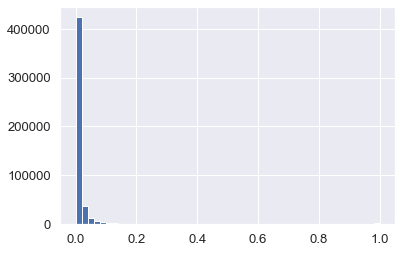

In [90]:
sub.loc[ sub['isFraud']>0.99 , 'isFraud'] = 1
b = plt.hist(sub['isFraud'], bins=50)

In [91]:
print ("Predicted {} frauds".format(int(sub[sub['isFraud']==1].sum())))

Predicted 1490 frauds
